In [21]:
# SET PATHS

# input data file location
input_path=r'C:\Users\boa\Documents\Repositories_Github\python-ehub\cases\hslu_exercises\input_data.xlsx'

# results location
results_path = 'C:/Users/boa/Documents/Repositories_Github/python-ehub/results/hslu_exercises/'

# set the experiment name
experiment = 'experiment1'


In [48]:
# IMPORT SOME STUFF

from run_mod import *
from gen_plots import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pylab
import os

In [49]:
# EXECUTE MODEL

from run_mod import *
from gen_plots import *

result_file = results_path + 'results.txt'
param_file = results_path + 'params.txt'
visualizations_directory = results_path

run_model(input_path, param_file, result_file) # defined in run_mod.py

generate_plots(input_path, param_file, result_file, experiment, visualizations_directory) #defined in gen_plots.py


Generating model sets...
Generating model variables...
Generating model parameters...
Generating model constraints...
- System constraints
- General technology constraints
- Specific technology constraints
- Network constraints
- Storage constraints
- Carbon constraints
- Cost constraints
Generating custom constraints/model specifications...
Defining objective...
Saving model parameter values to text file...
Preprocessing...
Running solver...
Academic license - for non-commercial use only
Changed value of parameter FeasibilityTol to 1e-05
   Prev: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
No parameters matching 'outlev' found
No parameters matching 'iisfind' found
Optimize a model with 692097 rows, 473068 columns and 1664461 nonzeros
Variable types: 332908 continuous, 140160 integer (140160 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 4e+07]
Presolve removed 639388 row

In [24]:
# LOAD RESULTS DATA

lines = []
with open (result_file, 'rt') as in_file:
    for line in in_file:
        lines.append(line) 
        
capacities = {}
capstor = []
eout = []
outstg = []
eimp = []
for row in lines:
    if(row.find("TotalCost") >= 0):
        row2 = row.split(sep=" ")
        total_cost = row2[2]
        
    if(row.find("IncomeExp") >= 0):
        row2 = row.split(sep=" ")
        total_income = row2[2]
        
    if(row.find("TotalCarbon") >= 0):
        row2 = row.split(sep=" ")
        total_carbon = row2[2]
    
    if(row.find("CapTech") >= 0):
        row2 = row.split(sep=" ")
        capacities.update({row2[2]: float(row2[3])})
        
    if(row.find("CapStg") >= 0):
        row2 = row.split(sep=" ")
        capstor.append(row2[2:5])
        
    if(row.find("Eout") >= 0):
        row2 = row.split(sep=" ")
        eout.append(row2[2:6])
        
    if(row.find("OutStg") >= 0):
        row2 = row.split(sep=" ")
        outstg.append(row2[2:6])
        
    if(row.find("Eimp") >= 0):
        row2 = row.split(sep=" ")
        eimp.append(row2[2:5])

capacities['heat_pump'] = capacities['1']
capacities['gas_boiler'] = capacities['2']
capacities['solar_PV'] = capacities['3']
if '4' in capacities:
    capacities['CHP_unit'] = capacities['4']
del capacities['1']
del capacities['2']
del capacities['3']
if '4' in capacities:
    del capacities['4']

capacities_stor = pd.DataFrame(capstor, columns = ['tech','ec','value'])
del capacities_stor['ec']
capacities_stor = capacities_stor.apply(pd.to_numeric)
capacities_stor['tech'] = capacities_stor['tech'].replace(1, 'battery')
capacities_stor['tech'] = capacities_stor['tech'].replace(2, 'hot_water_tank')
capacities_stor = capacities_stor.groupby(['tech']).sum()
#capacities_stor['battery'] = capacities_stor['1']
#capacities_stor['hot_water_tank'] = capacities_stor['2']
#del capacities_stor['1']
#del capacities_stor['2']

eoutdf = pd.DataFrame(eout, columns = ['tm', 'tech', 'ec', 'value'])
eoutdf = eoutdf.apply(pd.to_numeric)
eoutdf['tech'] = eoutdf['tech'].replace(1, 'heat_pump')
eoutdf['tech'] = eoutdf['tech'].replace(2, 'gas_boiler')
eoutdf['tech'] = eoutdf['tech'].replace(3, 'solar_PV')
eoutdf['tech'] = eoutdf['tech'].replace(4, 'CHP_unit')

stgoutdf = pd.DataFrame(outstg, columns = ['tm', 'tech', 'ec', 'value'])
stgoutdf = stgoutdf.apply(pd.to_numeric)
stgoutdf['tech'] = stgoutdf['tech'].replace(1, 'battery')
stgoutdf['tech'] = stgoutdf['tech'].replace(2, 'hot_water_tank')
eoutdf = eoutdf.append(stgoutdf)

eimpdf = pd.DataFrame(eimp, columns = ['tm', 'ec', 'value'])
eimpdf = eimpdf.apply(pd.to_numeric)
eimpdf['tech']='grid'
eoutdf = eoutdf.append(eimpdf)

electricity_production = eoutdf.loc[eoutdf['ec'] == 1]
heat_production = eoutdf.loc[eoutdf['ec'] == 2]

directory = visualizations_directory + experiment
if not os.path.exists(directory):
    os.makedirs(directory)
        

In [25]:
# TOTAL COSTS, INCOME & CARBON EMISSIONS

print("TOTAL COST (CHF) = " + str(round(float(total_cost))))
print("TOTAL INCOME (CHF) = " + str(round(float(total_income))))
print("TOTAL CARBON EMISSIONS (kg CO2-eq) = " + str(round(float(total_carbon))))

TOTAL COST (CHF) = 2307364
TOTAL INCOME (CHF) = 0
TOTAL CARBON EMISSIONS (kg CO2-eq) = 2113287


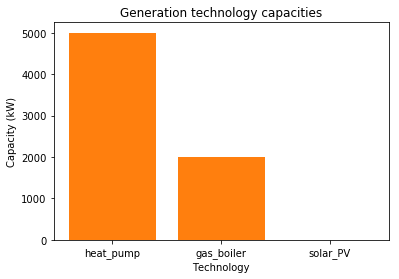

In [36]:
# CONVERSION TECHNOLOGY CAPACITIES

plt.bar(range(len(capacities)), list(capacities.values()), align='center')
plt.xticks(range(len(capacities)), list(capacities.keys()))
plt.xlabel('Technology')
plt.ylabel('Capacity (kW)')
plt.title('Generation technology capacities')
fig = plt.gcf()
fig.savefig(directory + '/capacities_conversion_technologies.pdf', format='pdf')
plt.show()


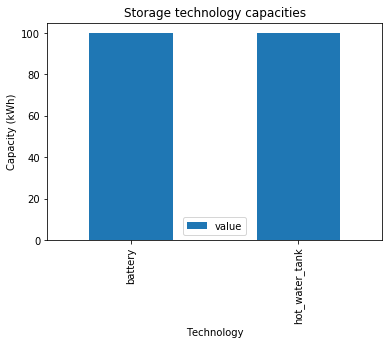

In [37]:
# STORAGE TECHNOLOGY CAPACITIES

cs = capacities_stor.copy(deep=True)
cs.plot(kind='bar')
plt.xlabel('Technology')
plt.ylabel('Capacity (kWh)')
plt.title('Storage technology capacities')
fig = plt.gcf()
fig.savefig(directory + '/capacities_storage_technologies.pdf', format='pdf')
plt.show()


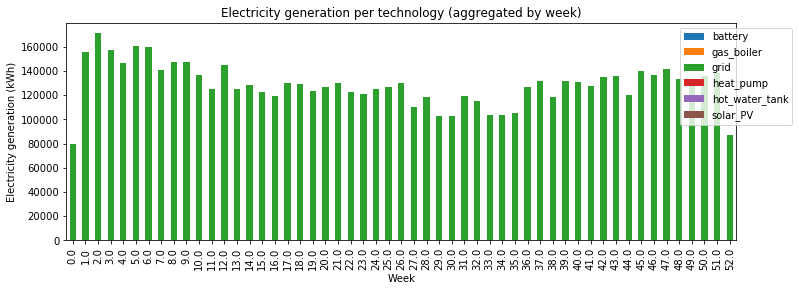

In [41]:
# ELECTRICITY PRODUCTION - AGGREGATED WEEKLY RESULTS

ep = electricity_production.copy(deep=True)
week = round(ep['tm']/(7*24))
ep['week'] = week
del ep['tm']
del ep['ec']
ep2 = ep.groupby(['week','tech']).sum()
ep2 = ep2.unstack()
ep2.columns = ep2.columns.droplevel()
ep2.plot(kind='bar', stacked=True)
plt.xlabel('Week')
plt.ylabel('Electricity generation (kWh)')
plt.title('Electricity generation per technology (aggregated by week)')
fig = plt.gcf()
fig.set_size_inches(12, 4, forward=True)
plt.legend(loc=9, bbox_to_anchor=(1.0, 1.0))
fig.savefig(directory + '/electricity_production_per_week.pdf', format='pdf')
plt.show()


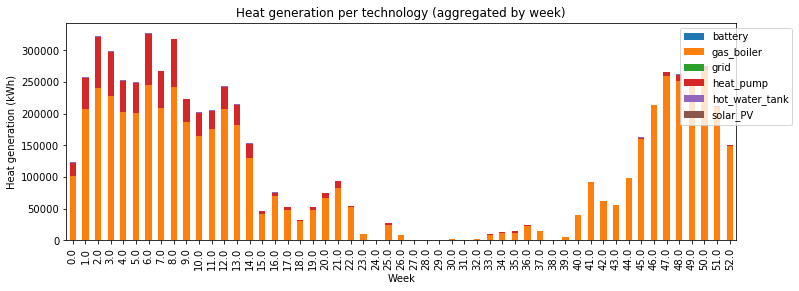

In [43]:
# HEAT PRODUCTION - AGGREGATED WEEKLY RESULTS
ep = heat_production.copy(deep=True)
week = round(ep['tm']/(7*24))
ep['week'] = week
del ep['tm']
del ep['ec']
ep2 = ep.groupby(['week','tech']).sum()
ep2 = ep2.unstack()
ep2.columns = ep2.columns.droplevel()
ep2.plot(kind='bar', stacked=True)
plt.xlabel('Week')
plt.ylabel('Heat generation (kWh)')
plt.title('Heat generation per technology (aggregated by week)')
fig = plt.gcf()
fig.set_size_inches(12, 4, forward=True)
plt.legend(loc=9, bbox_to_anchor=(1.0, 1.0))
fig.savefig(directory + '/heat_production_per_week.pdf', format='pdf')
plt.show()
